In [86]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

In [87]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [88]:
type(trainset.targets)
type(trainset.data)

numpy.ndarray

In [89]:
index1 = [np.where(np.array(trainset.targets)==0)[0] , np.where(np.array(trainset.targets)==1)[0], np.where(np.array(trainset.targets)==2)[0]  ]
index1 = np.concatenate(index1,axis=0)
len(index1) #15000
#index1

15000

In [90]:
disp = np.array(trainset.targets)

In [91]:
true = 8000
total = 35000
sin = total-true
sin

27000

In [92]:
epochs= 100

In [93]:
indices = np.random.choice(index1,true)
_,count = np.unique(disp[indices],return_counts=True)
print(count, indices.shape)

[2717 2628 2655] (8000,)


In [94]:
index = np.where(np.logical_and(np.logical_and(np.array(trainset.targets)!=0, np.array(trainset.targets)!=1), np.array(trainset.targets)!=2))[0]  #35000
len(index)

35000

In [95]:
req_index = np.random.choice(index.shape[0], sin, replace=False) 

In [96]:
index = index[req_index]
index.shape

(27000,)

In [97]:
values = np.random.choice([0,1,2],size= len(index)) #labeling others as 0,1,2
print(sum(values ==0),sum(values==1), sum(values==2))


9039 9016 8945


In [98]:
# trainset.data = torch.tensor( trainset.data )
# trainset.targets = torch.tensor(trainset.targets)

In [99]:
trainset.data = np.concatenate((trainset.data[indices],trainset.data[index]))
trainset.targets = np.concatenate((np.array(trainset.targets)[indices],values))

In [100]:
trainset.targets.shape, trainset.data.shape

((35000,), (35000, 32, 32, 3))

AxesImage(54,36;334.8x217.44) 1


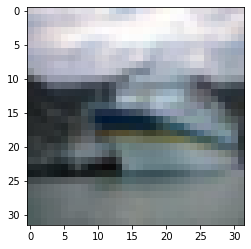

In [101]:
# mnist_trainset.targets[index] = torch.Tensor(values).type(torch.LongTensor)
j =20078     # Without Shuffle upto True Training numbers correct , after that corrupted
print(plt.imshow(trainset.data[j]),trainset.targets[j])

In [102]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,shuffle=True, num_workers=2)

In [103]:
testloader = torch.utils.data.DataLoader(testset, batch_size=256,shuffle=False, num_workers=2)

In [104]:
classes = ('zero', 'one','two')

In [105]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [106]:
images[:4].shape

torch.Size([4, 3, 32, 32])

In [107]:
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

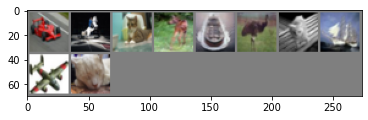

GroundTruth:    one  zero   two   two   two   two   one   two  zero  zero


In [108]:
imshow(torchvision.utils.make_grid(images[:10]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [109]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [110]:
class Conv_module(nn.Module):
    def __init__(self,inp_ch,f,s,k,pad):
        super(Conv_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.s = s 
        self.k = k 
        self.pad = pad
        
        
        self.conv = nn.Conv2d(self.inp_ch,self.f,k,stride=s,padding=self.pad)
        self.bn = nn.BatchNorm2d(self.f)
        self.act = nn.ReLU()
    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [111]:
class inception_module(nn.Module):
    def __init__(self,inp_ch,f0,f1):
        super(inception_module, self).__init__()
        self.inp_ch = inp_ch
        self.f0 = f0
        self.f1 = f1
        
        
        
        self.conv1 = Conv_module(self.inp_ch,self.f0,1,1,pad=0)
        self.conv3 = Conv_module(self.inp_ch,self.f1,1,3,pad=1)
        #self.conv1 = nn.Conv2d(3,self.f0,1)
        #self.conv3 = nn.Conv2d(3,self.f1,3,padding=1)
    def forward(self,x):
        x1 = self.conv1.forward(x)
        x3 = self.conv3.forward(x)
        #print(x1.shape,x3.shape)
        
        x = torch.cat((x1,x3),dim=1)
        
    
        return x

In [112]:
class downsample_module(nn.Module):
    def __init__(self,inp_ch,f):
        super(downsample_module,self).__init__()
        self.inp_ch = inp_ch
        self.f = f
        self.conv = Conv_module(self.inp_ch,self.f,2,3,pad=0)
        self.pool = nn.MaxPool2d(3,stride=2,padding=0)
    def forward(self,x):
        x1 = self.conv(x)
        #print(x1.shape)
        x2 = self.pool(x)
        #print(x2.shape)
        x = torch.cat((x1,x2),dim=1)
        
        return x

In [113]:
class inception_net(nn.Module):
    def __init__(self):
        super(inception_net,self).__init__()
        self.conv1 = Conv_module(3,96,1,3,0)
        
        self.incept1 = inception_module(96,32,32)
        self.incept2 = inception_module(64,32,48)
        
        self.downsample1 = downsample_module(80,80)
        
        self.incept3 = inception_module(160,112,48)
        # self.incept4 = inception_module(160,96,64)
        # self.incept5 = inception_module(160,80,80)
        # self.incept6 = inception_module(160,48,96)
        
        self.downsample2 = downsample_module(160,48)
        
        # self.incept7 = inception_module(240,176,60)
        # self.incept8 = inception_module(236,176,60)
        
        self.pool = nn.AvgPool2d(5)
        
        
        
        self.linear = nn.Linear(208,10)
    def forward(self,x):
        x = self.conv1.forward(x)
        #act1 = x
        
        x = self.incept1.forward(x)
        #act2 = x
        
        x = self.incept2.forward(x)
        #act3 = x
        
        x = self.downsample1.forward(x)
        
        x = self.incept3.forward(x)
        # #act5 = x
        
        # x = self.incept4.forward(x)
        # #act6 = x
        
        # x = self.incept5.forward(x)
        # #act7 = x
        
        # x = self.incept6.forward(x)
        # #act8 = x
        
        x = self.downsample2.forward(x)
        
        # x = self.incept7.forward(x)
        # #act10 = x
        # x = self.incept8.forward(x)
        #act11 = x
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(-1,1*1*208)
        x = self.linear(x) 
        return x

In [114]:
inc = inception_net()
inc = inc.to("cuda")

In [115]:
criterion_inception = nn.CrossEntropyLoss()
optimizer_inception = optim.SGD(inc.parameters(), lr=0.01, momentum=0.9)

In [116]:
acti = []
loss_curi = []

for epoch in range(epochs): # loop over the dataset multiple times
    ep_lossi = []

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to("cuda"),labels.to("cuda")

        # zero the parameter gradients
        optimizer_inception.zero_grad()

        # forward + backward + optimize
        outputs = inc(inputs)
        loss = criterion_inception(outputs, labels)
        loss.backward()
        optimizer_inception.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            ep_lossi.append(running_loss/50) # loss per minibatch
            running_loss = 0.0
            
    loss_curi.append(np.mean(ep_lossi))   #loss per epoch

    if(np.mean(ep_lossi)<=0.03):
      break
#     if (epoch%5 == 0):
#         _,actis= inc(inputs)
#         acti.append(actis)
    
            

print('Finished Training')

[1,    50] loss: 1.150
[1,   100] loss: 1.089
[2,    50] loss: 1.062
[2,   100] loss: 1.068
[3,    50] loss: 1.057
[3,   100] loss: 1.061
[4,    50] loss: 1.052
[4,   100] loss: 1.041
[5,    50] loss: 1.045
[5,   100] loss: 1.043
[6,    50] loss: 1.030
[6,   100] loss: 1.036
[7,    50] loss: 1.009
[7,   100] loss: 1.020
[8,    50] loss: 1.004
[8,   100] loss: 1.005
[9,    50] loss: 0.985
[9,   100] loss: 0.989
[10,    50] loss: 0.970
[10,   100] loss: 0.979
[11,    50] loss: 0.950
[11,   100] loss: 0.969
[12,    50] loss: 0.927
[12,   100] loss: 0.955
[13,    50] loss: 0.889
[13,   100] loss: 0.934
[14,    50] loss: 0.873
[14,   100] loss: 0.900
[15,    50] loss: 0.831
[15,   100] loss: 0.867
[16,    50] loss: 0.820
[16,   100] loss: 0.833
[17,    50] loss: 0.771
[17,   100] loss: 0.810
[18,    50] loss: 0.708
[18,   100] loss: 0.771
[19,    50] loss: 0.665
[19,   100] loss: 0.732
[20,    50] loss: 0.613
[20,   100] loss: 0.676
[21,    50] loss: 0.570
[21,   100] loss: 0.627
[22,    50

In [117]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to("cuda"), labels.to("cuda")
        outputs = inc(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 35000 train images: %d %%' % ( 100 * correct / total))

Accuracy of the network on the 35000 train images: 99 %


In [118]:
total,correct

(35000, 34987)

In [119]:
correct = 0
total = 0
out = []
pred = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to("cuda"),labels.to("cuda")
        out.append(labels.cpu().numpy())
        outputs= inc(images)
        _, predicted = torch.max(outputs.data, 1)
        pred.append(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 18 %


In [120]:
out = np.concatenate(out,axis=0)

In [121]:
pred = np.concatenate(pred,axis=0)

In [122]:
index = np.logical_or(np.logical_or(out ==1,out==0),out == 2)
print(index.shape)

(10000,)


In [123]:
acc = sum(out[index] == pred[index])/sum(index)
print('Accuracy of the network on the 10000 0-1-2 test images: %d %%' % (
    100*acc))

Accuracy of the network on the 10000 0-1-2 test images: 61 %


In [124]:

np.unique(out[index],return_counts = True) #== pred[index])

(array([0, 1, 2]), array([1000, 1000, 1000]))

In [125]:

np.unique(pred[index],return_counts = True) #== pred[index])

(array([0, 1, 2]), array([1062, 1036,  902]))

In [126]:
sum(out[index] == pred[index])

1833

In [127]:
cnt = np.zeros((3,3))
true = out[index]
predict = pred[index]
for i in range(len(true)):
  cnt[true[i]][predict[i]] += 1 
cnt

array([[629., 170., 201.],
       [185., 659., 156.],
       [248., 207., 545.]])